# load useful libraries

In [14]:
from libraries import *
from parameters import *

from warnings import filterwarnings
filterwarnings('ignore')
from itertools import compress

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.8.1 pandas==1.4.3 scikit-learn==1.1.1 statsmodels==0.13.2 python-igraph==0.10.2 pynndescent==0.5.7


In [15]:
os.getcwd()
os.chdir(projectDir)

# read data

In [84]:
adata = sc.read_h5ad('./DATA/sc_training.h5ad')
# adata.obs['n_umis']  = adata.layers['rawcounts'].sum(1)
# adata.obs['n_genes'] = (adata.layers['rawcounts'] != 0).sum(1).A1

# # MT
# mt_gene_mask = adata.var_names.str.startswith('mt-')
# assert mt_gene_mask.sum() > 0, 'Wrong mt prefix'
# adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1).A1 / adata.obs['n_umis']
# adata.write('./DATA/sc_training.h5ad')

In [85]:
adata.obs

,gRNA_maxID,state,condition,lane,n_umis,n_genes,mt_frac
053l1_AAACCTGAGATGTCGG-1,ONE-NON-GENE-SITE-7,terminal exhausted,Unperturbed,lane1,7487.0,2244,0.001925
053l1_AAACCTGAGCAACGGT-1,Tox2-3,effector,Tox2,lane1,8028.0,2286,0.002296
053l1_AAACCTGAGTACGACG-1,Tpt1-2,effector,Tpt1,lane1,4994.0,1620,0.003228
053l1_AAACCTGAGTCGTTTG-1,Tox2-3,terminal exhausted,Tox2,lane1,1711.0,826,0.007899
053l1_AAACCTGAGTGAAGAG-1,Tcf7-2,effector,Tcf7,lane1,5852.0,1979,0.002822
...,...,...,...,...,...,...,...
053l4_TTTGTCATCAGGTTCA-1,Tox2-3,other,Tox2,lane4,1392.0,753,0.018279
053l4_TTTGTCATCAGTGTTG-1,Dvl2-3,cycling,Dvl2,lane4,14277.0,3370,0.001146
053l4_TTTGTCATCCTCGCAT-1,Zeb2-2,cycling,Zeb2,lane4,7410.0,2300,0.002568
053l4_TTTGTCATCTTCAACT-1,Sox4-3,cycling,Sox4,lane4,10703.0,2755,0.001542


In [86]:
adata.X = adata.layers['rawcounts'].copy()
sc.pp.normalize_total(adata, target_sum=10000)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
sc.pp.scale(adata, max_value=10)

sc.pp.pca(adata, n_comps=50, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, metric="euclidean")

sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.8)
sc.tl.diffmap(adata)

normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:29)
running Leiden clustering
    finished: found 16 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:06)
computing Diffusio

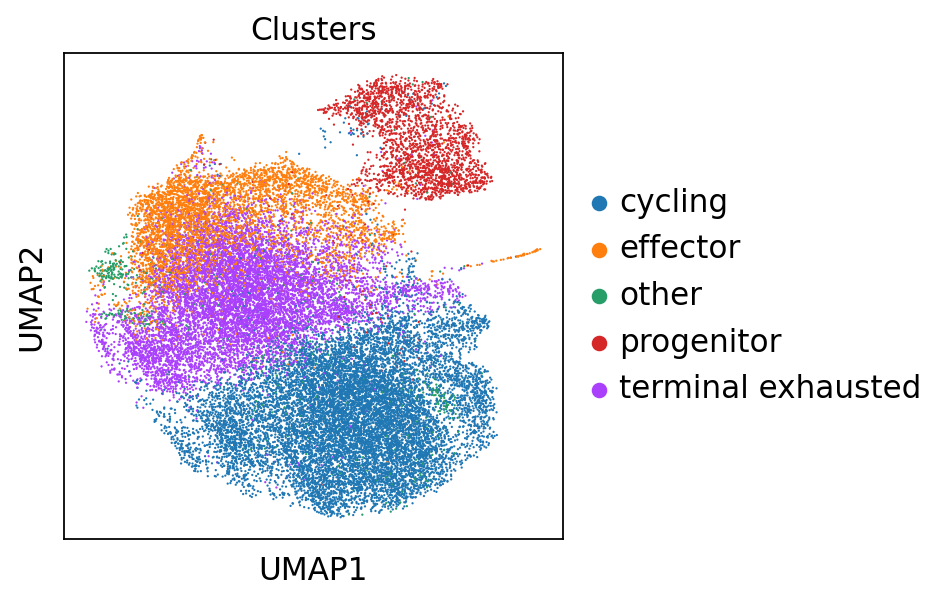

In [28]:
f, ax = plt.subplots(figsize=(4, 4))
sc.pl.umap(adata, color='state', 
           #legend_loc='on data', 
           legend_fontoutline=3, 
           legend_fontsize=14, 
           legend_fontweight='normal', 
           title='Clusters', 
           ax=ax, 
           show=False);

In [129]:
sc.tl.rank_genes_groups(adata, groupby="state", n_genes=2000, method="t-test_overestim_var")
markerGenes = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
markerGenes = markerGenes.iloc[0:10,:]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:11)


In [133]:
markerGenes = list(markerGenes.melt().value)

In [186]:
pd.Series(markerGenes).to_csv("./DATA/MarkerGenes.csv")

In [180]:
perturbations = list(adata.obs['condition'].unique())
perturbations.remove('Unperturbed')
k = [x in adata.var_names for x in perturbations]
perturbations = list(compress(perturbations, k))

In [181]:
testKOs=[ 'Aqr', 'Bach2', 'Bhlhe40', 'Ets1', 'Fosb', 'Mafk', 'Stat3']
[x in adata.var_names for x in testKOs]

[True, True, True, True, True, True, True]

In [182]:
expVar = pd.DataFrame(adata.X)
expVar.columns = adata.var_names
expVar

,Mrpl15,Lypla1,Tcea1,Atp6v1h,Rb1cc1,4732440D04Rik,Pcmtd1,Gm26901,Rrs1,Adhfe1,...,Slc3a1,Cfap53,Pstpip2,Gm17227,Ms4a8a,9130016M20Rik,Htr7,Col17a1,Awat2,Amot
0,0.456960,-0.845509,-1.480273,-0.574908,-0.611389,-0.211039,-0.522699,-0.051777,-0.658954,-0.019112,...,-0.010073,-0.008238,-0.013997,-0.013671,-0.013805,-0.013442,-0.009976,-0.005903,-0.014225,-0.008985
1,0.384419,0.889964,0.628678,-0.574908,-0.611389,-0.211039,-0.522699,-0.051777,1.329558,-0.019112,...,-0.010073,-0.008238,-0.013997,-0.013671,-0.013805,-0.013442,-0.009976,-0.005903,-0.014225,-0.008985
2,-1.108882,-0.845509,-1.480273,-0.574908,-0.611389,-0.211039,2.403685,-0.051777,-0.658954,-0.019112,...,-0.010073,-0.008238,-0.013997,-0.013671,-0.013805,-0.013442,-0.009976,-0.005903,-0.014225,-0.008985
3,-1.108882,-0.845509,-1.480273,-0.574908,-0.611389,-0.211039,-0.522699,-0.051777,-0.658954,-0.019112,...,-0.010073,-0.008238,-0.013997,-0.013671,-0.013805,-0.013442,-0.009976,-0.005903,-0.014225,-0.008985
4,-1.108882,-0.845509,-1.480273,-0.574908,-0.611389,-0.211039,-0.522699,-0.051777,-0.658954,-0.019112,...,-0.010073,-0.008238,-0.013997,-0.013671,-0.013805,-0.013442,-0.009976,-0.005903,-0.014225,-0.008985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28692,-1.108882,-0.845509,-1.480273,-0.574908,-0.611389,-0.211039,-0.522699,-0.051777,-0.658954,-0.019112,...,-0.010073,-0.008238,-0.013997,-0.013671,-0.013805,-0.013442,-0.009976,-0.005903,-0.014225,-0.008985
28693,0.507787,0.293351,0.772363,0.820838,-0.611389,-0.211039,-0.522699,-0.051777,-0.658954,-0.019112,...,-0.010073,-0.008238,-0.013997,-0.013671,-0.013805,-0.013442,-0.009976,-0.005903,-0.014225,-0.008985
28694,-1.108882,-0.845509,-1.480273,1.670924,1.423774,-0.211039,-0.522699,-0.051777,-0.658954,-0.019112,...,-0.010073,-0.008238,-0.013997,-0.013671,-0.013805,-0.013442,-0.009976,-0.005903,-0.014225,-0.008985
28695,0.108947,-0.845509,-0.367400,-0.574908,0.960474,-0.211039,-0.522699,-0.051777,0.962733,-0.019112,...,-0.010073,-0.008238,-0.013997,-0.013671,-0.013805,-0.013442,-0.009976,-0.005903,-0.014225,-0.008985


In [183]:
geneList = np.unique(perturbations + testKOs+markerGenes)
myGenesExp = expVar.loc[:,geneList]
corCoefs = pd.DataFrame(np.corrcoef(np.transpose(myGenesExp)))

corCoefs.columns = geneList
corCoefs.index = geneList
corCoefs

,Actb,Aqr,Arid4b,Arid5b,Atf2,B2m,Bach2,Batf,Bhlhe40,Birc5,...,Zeb2,Zfp292,mt-Atp6,mt-Atp8,mt-Co1,mt-Co2,mt-Co3,mt-Cytb,mt-Nd1,mt-Nd4l
Actb,1.000000,0.049236,-0.041056,-0.027017,0.000754,0.031801,-0.156698,-0.002566,-0.057931,0.206797,...,0.034716,0.008529,-0.059807,-0.050642,-0.216384,-0.132966,-0.114196,-0.013061,-0.034514,-0.048712
Aqr,0.049236,1.000000,-0.003557,0.022444,-0.001680,-0.051694,-0.003466,0.010657,0.029228,0.049331,...,0.018066,0.023490,0.033905,0.006493,-0.025747,-0.002801,-0.004347,0.033416,0.033425,0.025526
Arid4b,-0.041056,-0.003557,1.000000,0.032326,0.002106,0.025176,0.034291,0.014990,0.040151,-0.043332,...,0.019873,0.037113,0.052843,0.021217,0.083973,0.034299,0.045001,0.022416,0.012464,0.004298
Arid5b,-0.027017,0.022444,0.032326,1.000000,0.021663,0.059853,0.033264,0.041190,0.064117,-0.022096,...,0.042233,0.043419,0.069045,0.010489,0.087659,0.048301,0.034802,0.002972,0.023566,-0.001939
Atf2,0.000754,-0.001680,0.002106,0.021663,1.000000,0.009231,0.009275,0.012120,0.033393,0.021849,...,0.020841,0.026070,0.037439,0.004092,0.024613,0.012688,-0.000023,0.018370,0.024595,0.006477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mt-Co2,-0.132966,-0.002801,0.034299,0.048301,0.012688,-0.028544,0.038627,-0.000489,-0.025511,-0.050898,...,0.009294,0.025431,0.294843,0.268771,0.388507,1.000000,0.404068,0.270711,0.245284,0.263592
mt-Co3,-0.114196,-0.004347,0.045001,0.034802,-0.000023,0.022951,0.023466,-0.017237,-0.058016,-0.116799,...,0.009223,0.046178,0.273124,0.282515,0.457360,0.404068,1.000000,0.229073,0.220755,0.253432
mt-Cytb,-0.013061,0.033416,0.022416,0.002972,0.018370,-0.154374,0.007464,0.003891,0.020447,0.046978,...,0.017960,0.028495,0.210353,0.230165,0.157952,0.270711,0.229073,1.000000,0.244012,0.345880
mt-Nd1,-0.034514,0.033425,0.012464,0.023566,0.024595,-0.074007,0.002405,0.019010,-0.013172,0.064557,...,0.014489,0.022003,0.210403,0.183742,0.128416,0.245284,0.220755,0.244012,1.000000,0.243951


In [184]:
corCoefs.to_csv("./DATA/ExpCorCoefs.csv")

## Identify and plot cluster marker genes

In [148]:
len(markerGenes)

50

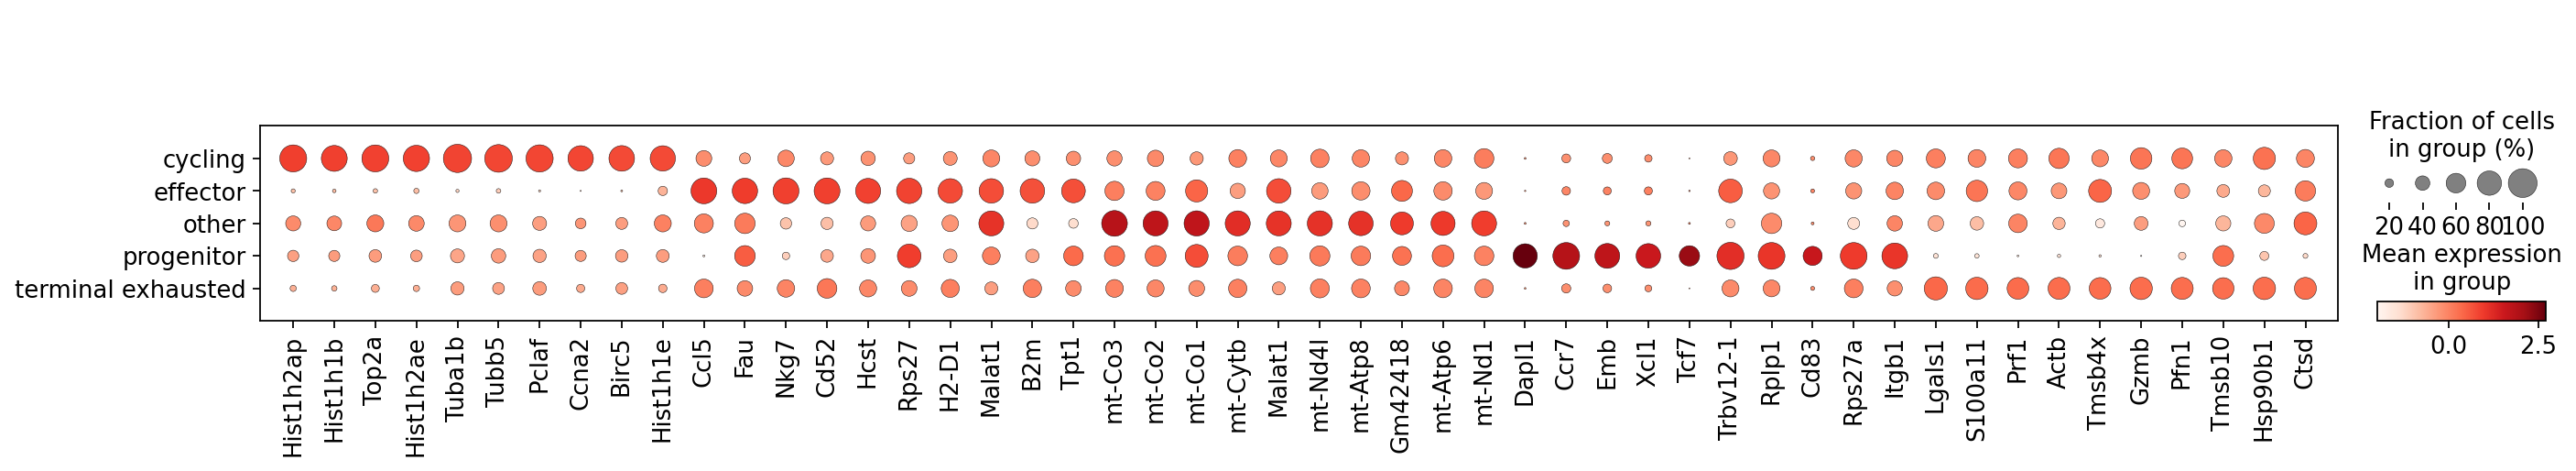

In [82]:
sc.pl.dotplot(adata, markerGenes, groupby='state')

# adata.X stores the stadard-normalized data, but you can also reconstruct it using adata.layers['rawcounts']

In [7]:
# make a copy of normalized logcounts
adata.layers['normalized_logcounts'] = adata.X.copy()

In [8]:
# standard normalization
adata.X = adata.layers['rawcounts'].copy()

sc.pp.normalize_total(adata, target_sum=5e3)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


# Visualize cell state clusters on umap

In [9]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=50)
sc.tl.umap(adata, min_dist=0.3) 

computing PCA
    with n_comps=50
    finished (0:00:38)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:19)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:37)


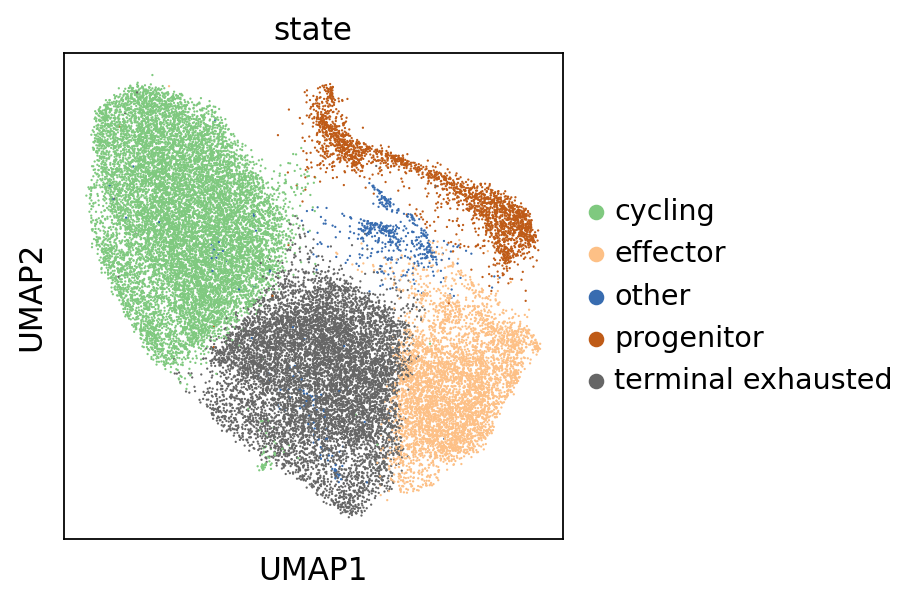

In [10]:
sc.pl.umap(adata, color=['state'], palette='Accent', legend_loc='right margin')

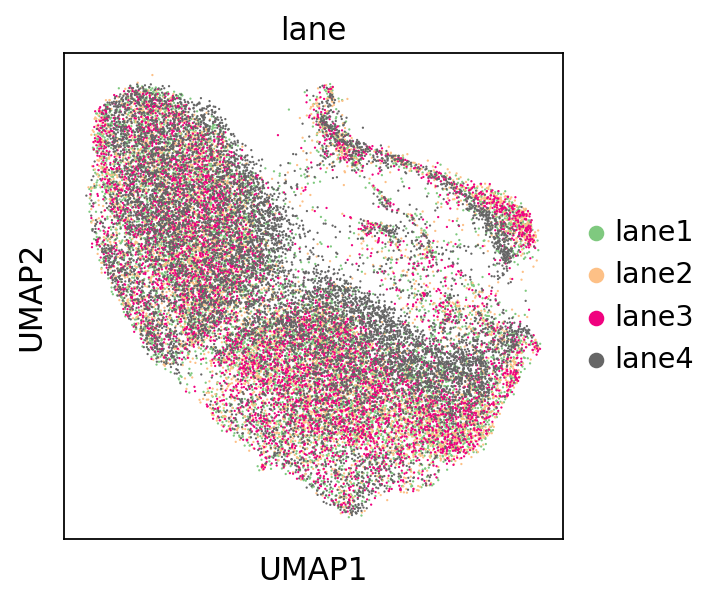

In [11]:
sc.pl.umap(adata, color=['lane'], palette='Accent', legend_loc='right margin')

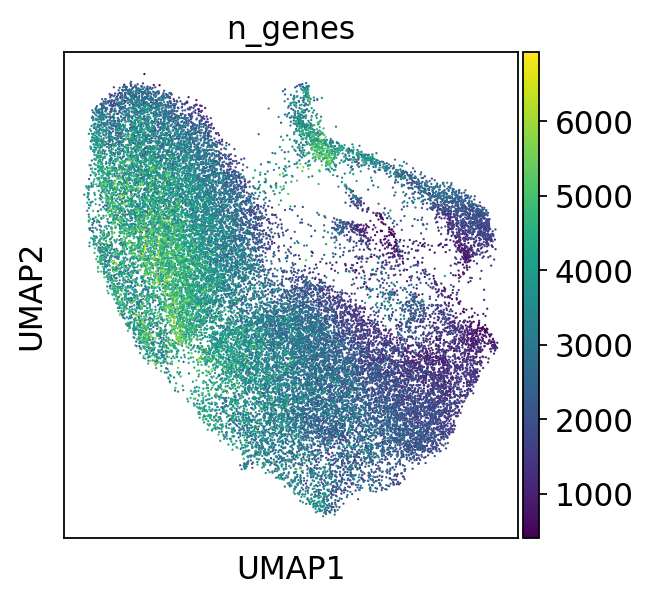

In [12]:
sc.pl.umap(adata, color=['n_genes'], palette='Accent', legend_loc='right margin')

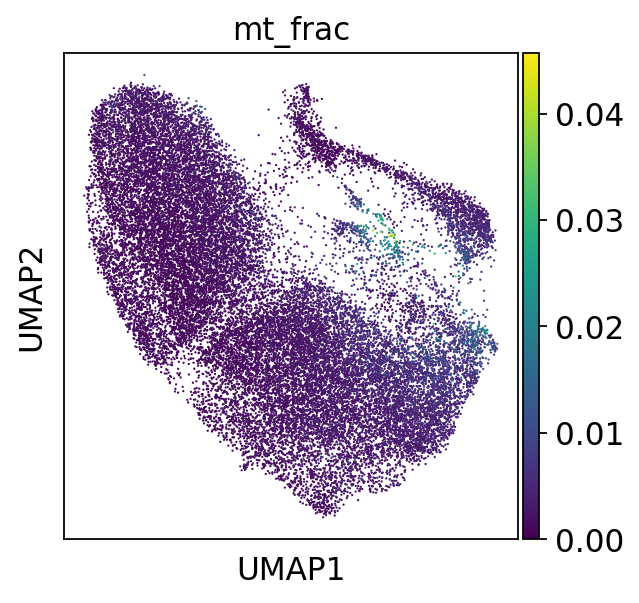

In [13]:
sc.pl.umap(adata, color=['mt_frac'], palette='coolwarm', legend_loc='right margin')

In [14]:
pd.crosstab(adata.obs.condition,adata.obs.lane).to_csv("./DATA/KO_lane.csv")

In [15]:
pd.crosstab(adata.obs.gRNA_maxID,adata.obs.lane).to_csv("./DATA/Guide_lane.csv")

In [16]:
pd.crosstab(adata.obs.gRNA_maxID,adata.obs.state).to_csv("./DATA/Guide_state.csv")

In [17]:
pd.crosstab(adata.obs.gRNA_maxID,adata.obs.state).to_csv("./DATA/Guide_state.csv")

In [18]:
myDF = pd.crosstab(adata.obs.gRNA_maxID,adata.obs.state)

In [19]:
myDF

state,cycling,effector,other,progenitor,terminal exhausted
gRNA_maxID,,,,,
Arid4b-1,17,9,0,11,12
Arid4b-2,189,39,6,14,188
Arid4b-3,65,27,1,11,47
Arid5b-1,1070,94,34,12,910
Arid5b-2,157,10,5,10,80
...,...,...,...,...,...
Zeb2-2,196,52,5,7,125
Zeb2-3,14,7,2,4,10
Zfp292-1,41,160,1,12,17


In [20]:
myDF.div(myDF.sum(axis=1), axis=0).to_csv("./DATA/Guide_state_perc.csv")

In [21]:
k=myDF.sum(axis=1)

In [22]:
k.sort_values().to_csv("./DATA/Guide_abundance_sorted.csv")

In [23]:
hehe = adata.obs.condition.value_counts()

In [24]:
hehe[hehe < 10]

Batf     6
Klf2     5
Tbx21    2
Rps6     2
Eef2     1
Name: condition, dtype: int64

In [25]:
myDF_2 = pd.crosstab(adata.obs.condition,adata.obs.state)

In [26]:
myDF_2

state,cycling,effector,other,progenitor,terminal exhausted
condition,,,,,
Arid4b,271,75,7,36,247
Arid5b,1234,107,42,27,992
Atf2,42,35,4,17,43
Batf,0,0,1,4,1
Crem,235,324,13,26,163
...,...,...,...,...,...
Tpt1,7,4,0,11,3
Unperturbed,1952,1044,86,336,1560
Yy1,3,5,0,15,2


In [27]:
res = myDF_2.div(myDF_2.sum(axis=1), axis=0)

In [29]:
res.to_csv("./DATA/KO_state_perc.csv")

In [72]:
adata.obs.state.value_counts() / sum(adata.obs.state.value_counts())

cycling               0.425201
terminal exhausted    0.312820
effector              0.161724
progenitor            0.079660
other                 0.020594
Name: state, dtype: float64

In [74]:
adata.obs.state.value_counts()

cycling               12202
terminal exhausted     8977
effector               4641
progenitor             2286
other                   591
Name: state, dtype: int64